In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# Classification problem with HWW ATLAS Open data using Machine Learning

In this exercise you are given 3 files with tabular data split by 3 sets, respectively:

 * Set of events for training the ML classifier (data_train.csv)
 * Set of events for validating the ML classifier (data_val.csv)
 * Set of events for testing the ML classifier (data_test.csv)

The data content is the same used for the ML class, i.e.

 * there is a number of observables (mLL,pTLL, etc...);
 * a label indicating the true class of each event (0=background, 1=signal) included as a variable in the data frame;
 * an event weight to be used for training ("train_weight").

## Load and inspect data

* Open data files
* Inspect contents
* Plot variables

In [2]:
data_train = pd.read_csv("https://www.lip.pt/~rute/MASimHEP/HWW_csv_prep/data_train.csv")
data_val   = pd.read_csv("https://www.lip.pt/~rute/MASimHEP/HWW_csv_prep/data_val.csv")
data_test  = pd.read_csv("https://www.lip.pt/~rute/MASimHEP/HWW_csv_prep/data_test.csv")

data_train

,Unnamed: 0,mLL,ptLL,dPhi_LL,dPhiLLmet,MET,mt,goodjet_n,goodbjet_n,Lepton1_Pt,...,Lepton2_Eta,Lepton2_E,Lepton2_Phi,Lepton2_charge,Lepton2_type,weight,process,label,scale_weight,train_weight
0,147358,49.0513,61.2491,1.381790,3.02321,67.4356,128.3110,0,0,47.4727,...,-1.721170,88.8479,-0.235791,-1,11,0.988994,diboson,0,0.024622,0.000016
1,5771,19.9963,57.7996,0.699216,2.46491,61.4980,112.4800,1,0,40.3348,...,1.846730,67.4742,2.171550,1,11,31.823900,signal,1,0.003327,0.000016
2,76660,43.8206,96.2837,0.084119,2.31188,84.7958,165.3850,1,0,61.2737,...,0.502883,39.6200,-0.597652,-1,11,25.705100,signal,1,0.002687,0.000013
3,154078,49.4911,85.4053,1.037550,2.22171,93.4773,160.1300,1,0,61.2571,...,-0.131749,36.3402,-2.929180,-1,13,0.084681,diboson,0,0.002108,0.000001
4,73055,33.0773,60.7330,1.009950,2.83851,42.6602,100.6350,1,0,40.1756,...,0.329813,30.5285,2.296100,1,11,32.887200,signal,1,0.003438,0.000016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64055,5014,44.2874,59.5597,0.489036,2.80323,39.1230,95.1650,0,0,35.7962,...,0.418980,27.8105,1.029180,1,11,0.000000,signal,1,0.000000,0.000000
64056,173819,22.4984,68.0981,0.636690,2.88861,91.2377,156.3870,0,0,42.8521,...,2.259050,138.8700,-0.802207,1,13,0.981583,diboson,0,0.024438,0.000016
64057,153656,22.7315,61.5826,0.317995,3.08785,63.8451,125.3620,0,0,38.6547,...,-2.249690,113.4920,2.326470,-1,13,1.192730,diboson,0,0.029694,0.000020
64058,187006,42.2915,55.7519,0.391131,2.96568,29.7256,81.1042,0,0,39.6714,...,-0.463672,18.8450,2.831800,-1,13,1.180240,diboson,0,0.029383,0.000020


In [3]:
features = data_train.columns
features

Index(['Unnamed: 0', 'mLL', 'ptLL', 'dPhi_LL', 'dPhiLLmet', 'MET', 'mt',
       'goodjet_n', 'goodbjet_n', 'Lepton1_Pt', 'Lepton1_Eta', 'Lepton1_E',
       'Lepton1_Phi', 'Lepton1_charge', 'Lepton1_type', 'Lepton2_Pt',
       'Lepton2_Eta', 'Lepton2_E', 'Lepton2_Phi', 'Lepton2_charge',
       'Lepton2_type', 'weight', 'process', 'label', 'scale_weight',
       'train_weight'],
      dtype='object')

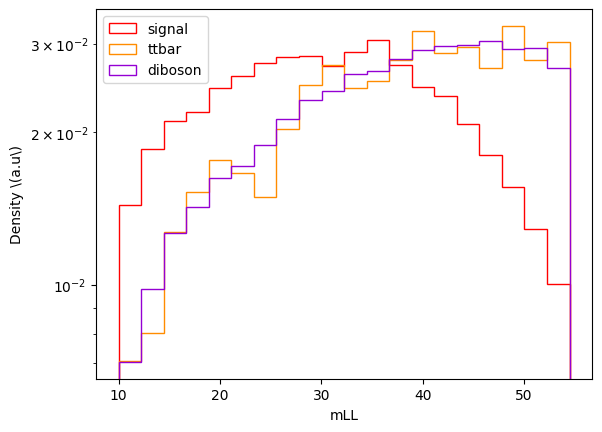

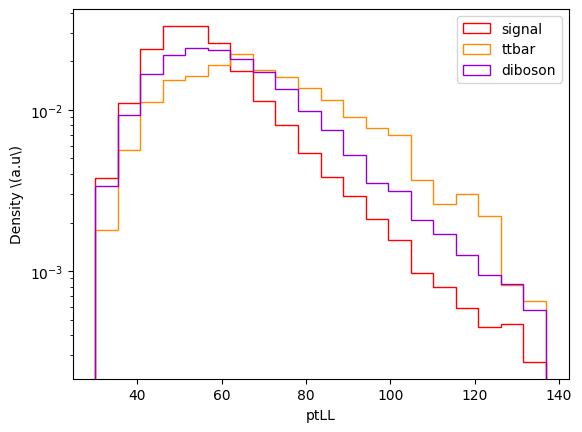

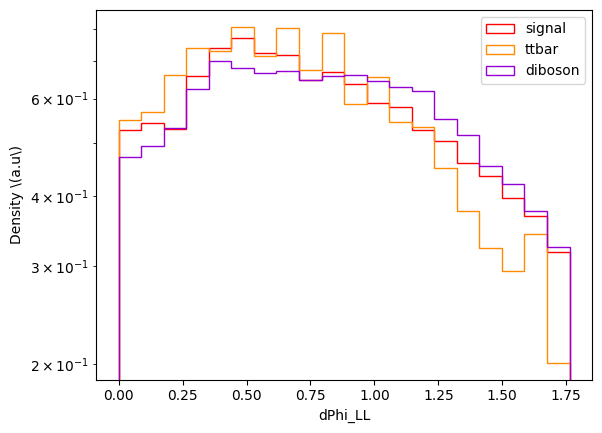

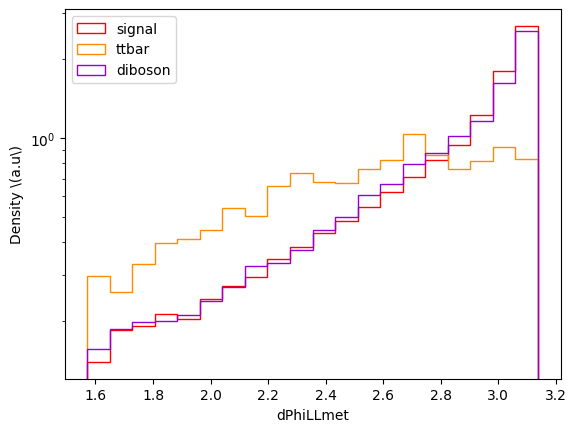

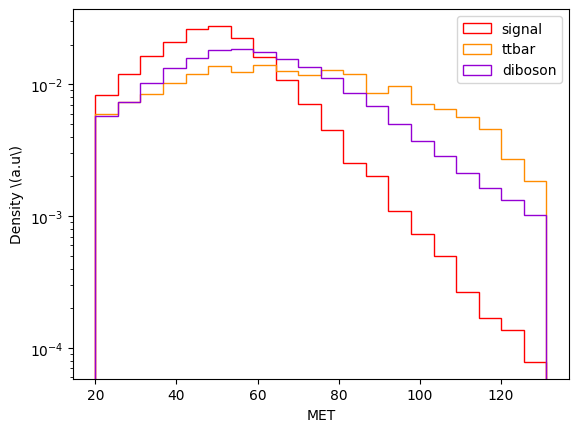

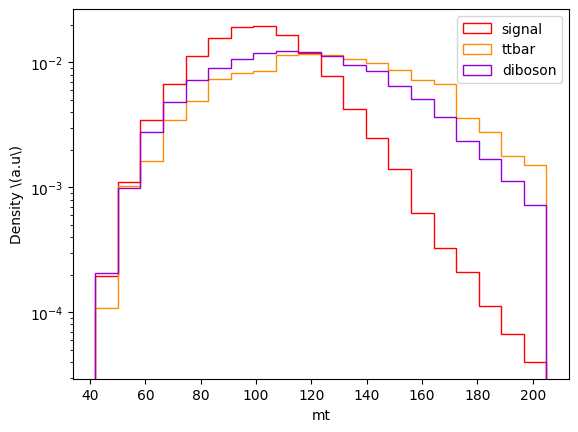

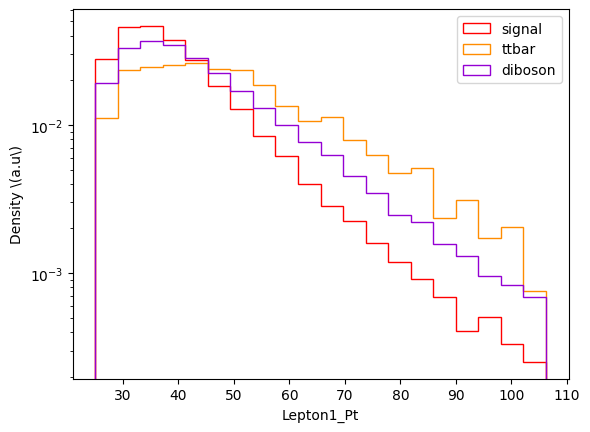

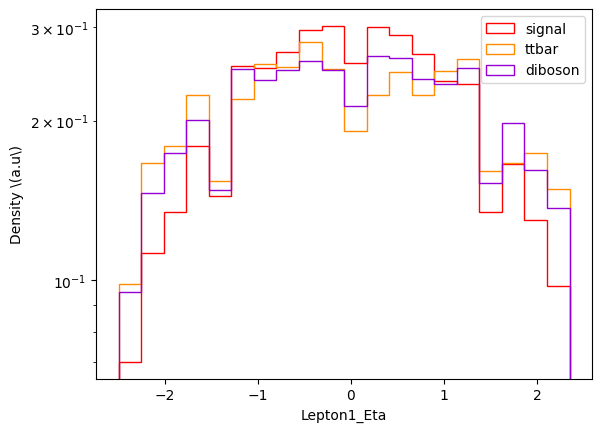

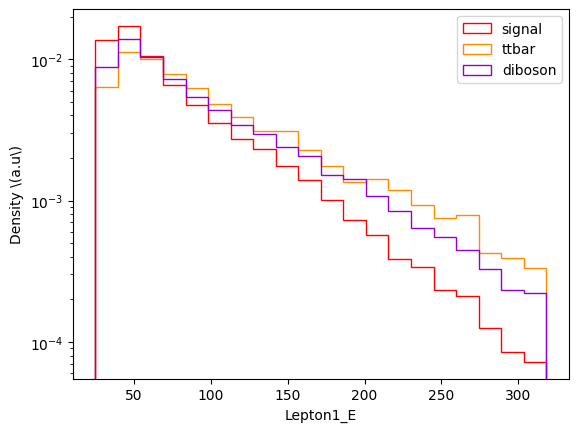

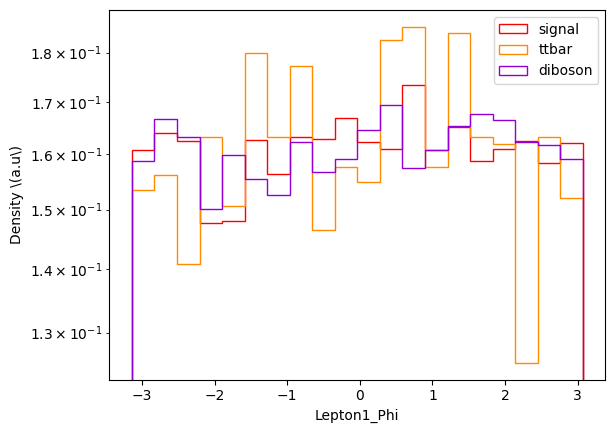

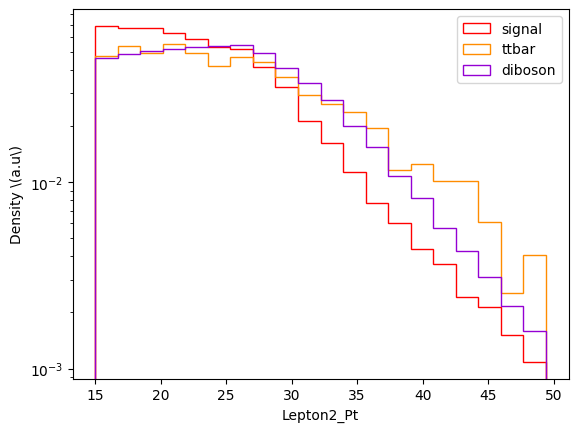

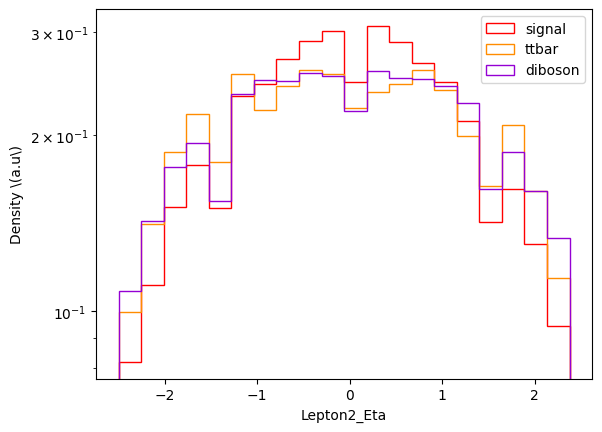

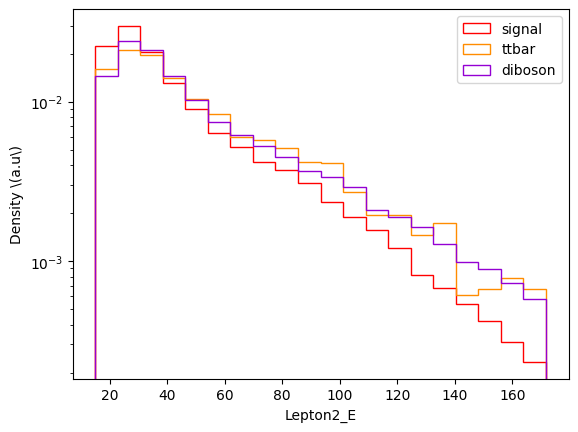

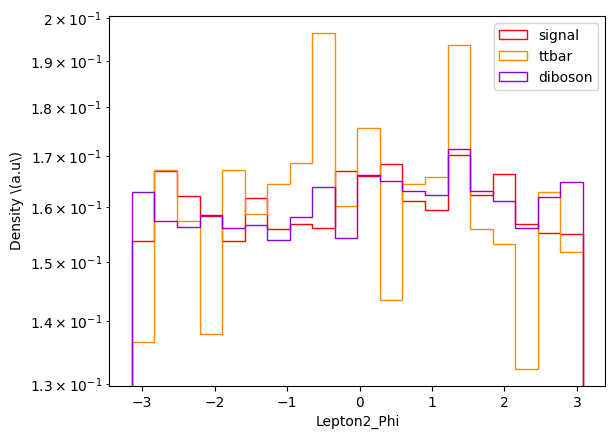

In [4]:
plot_features = ['mLL', 'ptLL', 'dPhi_LL', 'dPhiLLmet', 'MET', 'mt',
                 'Lepton1_Pt', 'Lepton1_Eta', 'Lepton1_E', 'Lepton1_Phi',
                 'Lepton2_Pt', 'Lepton2_Eta', 'Lepton2_E', 'Lepton2_Phi']

for feat in plot_features:

    #(We are filtering data signal out of the 99% quantile to get the bulk of the distribution and obtain decent axes limits...)
    bins = plt.hist(data_train.query(f'({feat} < {feat}.quantile(.99)) & (process=="signal")')[feat].values, bins=20, density=True, histtype='step', color='red', label='signal')
    plt.hist(data_train.query('process=="ttbar"')[feat].values, bins=bins[1], density=True, histtype='step', color='darkorange', label='ttbar')
    plt.hist(data_train.query('process=="diboson"')[feat].values, bins=bins[1], density=True, histtype='step', color='darkviolet', label='diboson')

    plt.xlabel(feat)
    plt.ylabel('Density \(a.u\)')
    plt.legend()
    plt.yscale("log")
    plt.show()

## Data pre-processing for training

* Define training 'features'
* Construct the inputs (x_train,x_val), weights (w_train,w_val) and target values (y_train,y_val) to train the classifier (in this step you obtain the exact same arrays as used in the ML class)

In [5]:
train_features = ['mLL', 'ptLL', 'dPhi_LL', 'dPhiLLmet', 'MET', 'mt', 'goodjet_n',
                 'goodbjet_n', 'Lepton1_Pt', 'Lepton1_Eta', 'Lepton1_E', 'Lepton1_Phi',
                 'Lepton1_charge', 'Lepton1_type', 'Lepton2_Pt', 'Lepton2_Eta',
                 'Lepton2_E', 'Lepton2_Phi', 'Lepton2_charge', 'Lepton2_type']

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data_train[train_features].values)

x_train = scaler.transform(data_train[train_features].values)
y_train = data_train['label'].values
w_train = data_train['train_weight'].values

x_val = scaler.transform(data_val[train_features].values)
y_val = data_val['label'].values
w_val = data_val['train_weight'].values

x_test = scaler.transform(data_test[train_features].values)
y_test = data_test['label'].values
w_test = data_test['train_weight'].values

print(f'Train sample x {len(x_train)} events (y {len(y_train)} events)')
print(f'Val   sample x {len(x_val)} events (y {len(y_val)} events)')
print(f'Test  sample x {len(x_test)} events (y {len(y_test)} events)')

Train sample x 64060 events (y 64060 events)
Val   sample x 64060 events (y 64060 events)
Test  sample x 64060 events (y 64060 events)


# Exercise 1: DNN - Deep Neural Network Classifier


In [7]:
from sklearn.metrics import roc_curve, roc_auc_score
import tensorflow as tf

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras import Input
from tensorflow.keras.optimizers import Adam
tf.random.set_seed(2)

## 1.a) DNN Training

Train a DNN with the hyperparameters below:

* 3 layers with 80, 95, 70 nodes respectively
* Learning rate of 8e-4
* 100 training epochs and Early Stopping with patience 4

In [8]:
# your answer
print(x_train.shape)
model = Sequential([Input(shape=(20,))])

# Input and Hidden layers

model.add(Dense(80, activation='relu'))
model.add(Dense(95, activation='relu'))
model.add(Dense(70, activation='relu'))

# Output layer
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=8e-4), weighted_metrics=['accuracy'])
model.summary()


(64060, 20)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 80)             │         1,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 95)             │         7,695 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 70)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,166 (63.15 KB)

 Trainable params: 16,166 (63.15 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(x_train, y_train, sample_weight=w_train, validation_data=(x_val, y_val, w_val), epochs=100, batch_size=1024, callbacks=[EarlyStopping(patience=4)])

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5516 - loss: 7.0865e-06 - val_accuracy: 0.6441 - val_loss: 6.7215e-06
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6415 - loss: 6.6649e-06 - val_accuracy: 0.6626 - val_loss: 6.4731e-06
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6617 - loss: 6.4375e-06 - val_accuracy: 0.6738 - val_loss: 6.2919e-06
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6694 - loss: 6.2837e-06 - val_accuracy: 0.6801 - val_loss: 6.1792e-06
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6742 - loss: 6.1899e-06 - val_accuracy: 0.6841 - val_loss: 6.1069e-06
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6775 - loss: 6.1291e-06 - val_accuracy: 0.6869 - val_loss: 6.0590e-06
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6780 - loss: 6.0877e-06 - val_accuracy: 0.6896 - val_loss: 6.0262e-06
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - ac

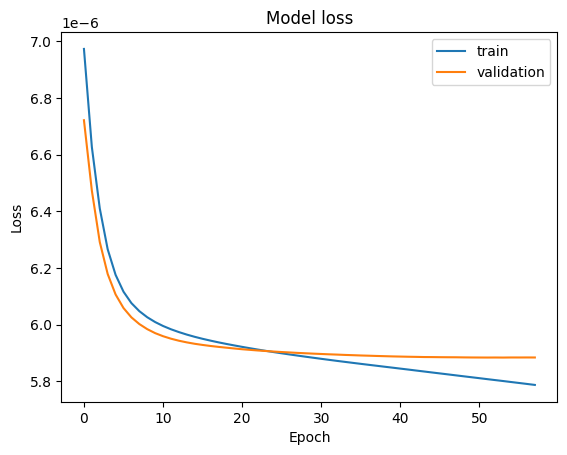

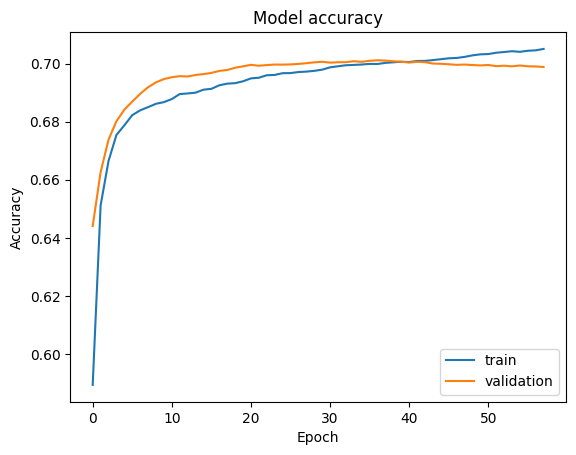

In [10]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


2002/2002 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step


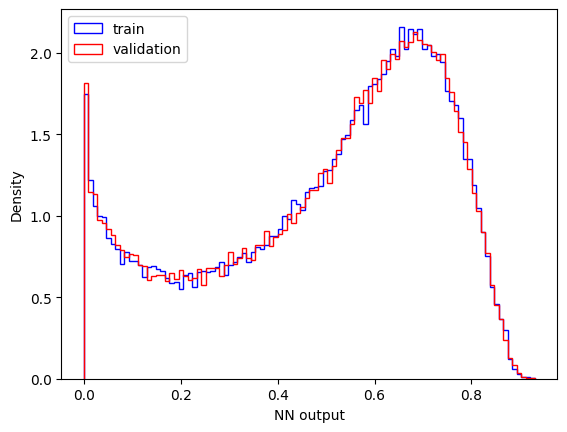

In [11]:
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)

bin = plt.hist(y_train_pred, bins=100, density=True, histtype='step', color='blue', label='train')
plt.hist(y_val_pred, bins=bin[1], density=True, histtype='step', color='red', label='validation')

plt.xlabel('NN output')
plt.ylabel('Density')
plt.legend()

## 1.b) Evaluate the DNN

* Plot the DNN output for signal and background and the Receiver Operating Characteristic (ROC) curve.
* What is the ROC Area Under the Curve (AUC)?

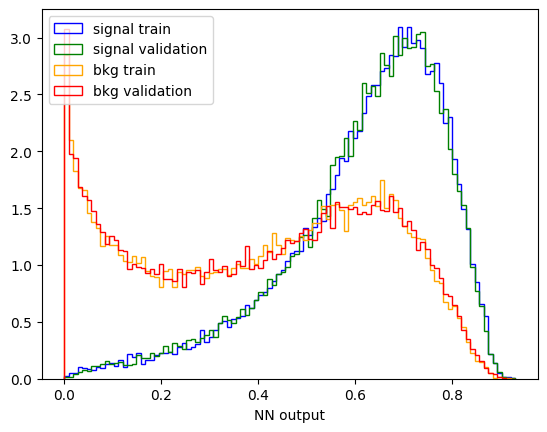

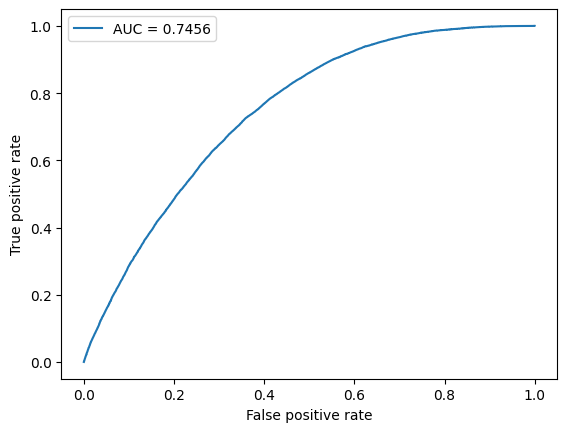

In [12]:
# your answer
bins = plt.hist(y_train_pred[y_train==1], bins=100, density=True, histtype='step', color='blue', label='signal train')
plt.hist(y_val_pred[y_val==1], bins=bins[1], density=True, histtype='step', color='green', label='signal validation')
plt.hist(y_train_pred[y_train==0], bins=bins[1], density=True, histtype='step', color='orange', label='bkg train')
plt.hist(y_val_pred[y_val==0], bins=bins[1], density=True, histtype='step', color='red', label='bkg validation')

plt.xlabel('NN output')
plt.legend()
plt.show()

# RPC curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred)
auc = roc_auc_score(y_val, y_val_pred)
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

# Exercise 2: RF - Random Forest Classifier


## 2.a) RF Training

Train a Random Forest Classifier with the hyperparameters below:

* Maximum depth of 3
* 40 decision trees (estimators)

**HINT:** The method to retreive the class prediction from the classifier for an input set of data x

```
predict_proba(x)
```
returns the probabilities of classification according to each class (0 or 1), such that

```
predict_proba(x)[:,0] # class-0 probability
predict_proba(x)[:,1] # class-1 probability
```




In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
# your answer
classifier = RandomForestClassifier(max_depth=3, n_estimators = 40)
classifier.fit(x_train, y_train, sample_weight=w_train)
score = classifier.score(x_test, y_test, sample_weight=w_test)

pred_train = classifier.predict_proba(x_train)
pred_val = classifier.predict_proba(x_val)

sig_pred_train = pred_train[:, 1]
sig_pred_val = pred_val[:,1]

## 2.b) Evaluate the RF

* Plot the classifier output for signal and background and the Receiver Operating Characteristic (ROC) curve.
* What is the ROC Area Under the Curve (AUC)?

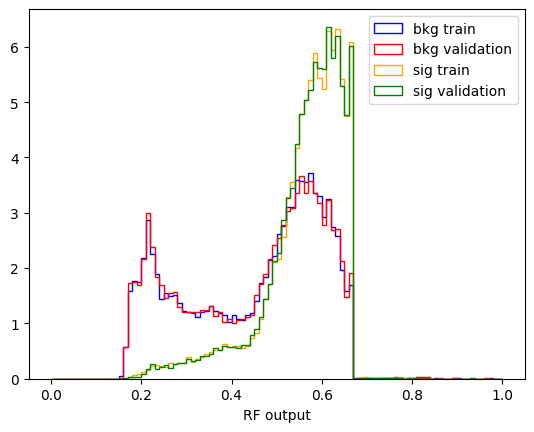

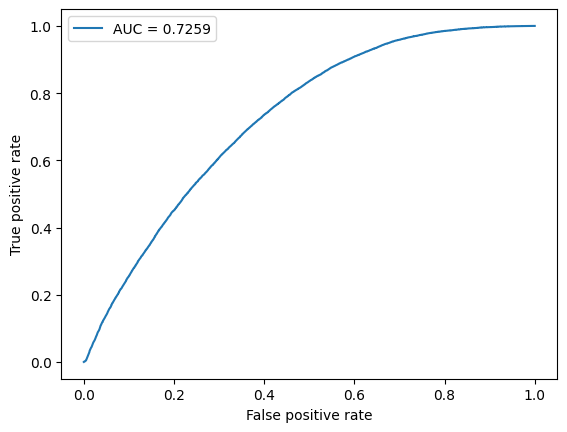

In [16]:
# your answer
bins = plt.hist(sig_pred_train[np.where(y_train==0)], bins=100, density=True, histtype='step', color='blue', label='bkg train', range=(0, 1))
plt.hist(sig_pred_val[np.where(y_val==0)], bins=bins[1], density=True, histtype='step', color='red', label='bkg validation', range=(0, 1))
plt.hist(sig_pred_train[np.where(y_train==1)], bins=bins[1], density=True, histtype='step', color='orange', label='sig train', range=(0, 1))
plt.hist(sig_pred_val[np.where(y_val==1)], bins=bins[1], density=True, histtype='step', color='green', label='sig validation', range=(0, 1))
plt.xlabel('RF output')
plt.legend()
plt.show()

fpr, tpr, _ = roc_curve(y_val, sig_pred_val)
auc = roc_auc_score(y_val, sig_pred_val)
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

# Exercise 3: DNN versus RF

Which method (DNN or Random Forest) has the best classification performance? Are these results in agreement with your expectations? Explain why.



Answer: The method with the best classification performance was the DNN, since it was the one with a higher value of the area under the ROC curve. The value for the DNN was 0.7456 and for the RF was 0.7259. This result is in agreement with the expectations, since the DNN is a more complex model than the RF: since a DNN is highly non-linear, it's expected to better model the data and have a better performance. It has more trainable parameters, which allows it to better adapt to the data. 
Although the DNN achieves better results, it is important to note that the RF is a simpler model and is easier to train and interpret, taking less computational resources. While this is not really relevant for the amount of data that we are using, at larger scales the training time and resources spent can easily become a bottleneck. The RF is also less prone to overfitting, which can be a problem for the DNN (solved by using early stopping).